# 01. Baseline Model Development
This notebook establishes the baseline performance for predicting vehicle loan default using the refined features from the Advanced EDA phase.

## 1. Environment Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('ggplot')
sns.set_palette('magma')

In [2]:
# Load refined dataset
df = pd.read_csv('../data/final_modeling_data.csv')
print(f"Dataset Shape: {df.shape}")
print("Columns:", df.columns.tolist())
df.head()

Dataset Shape: (233154, 21)
Columns: ['Young_High_LTV', 'SelfEmp_NoHistory', 'Triple_Threat', 'ltv', 'disbursed_amount', 'Age_at_Disbursal', 'PERFORM_CNS.SCORE', 'NO.OF_INQUIRIES', 'LTV_Risk_Score', 'Credit_History_Quality', 'Credit_Hunger', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'Employment.Type', 'State_ID', 'manufacturer_id', 'branch_id', 'loan_default']


,Young_High_LTV,SelfEmp_NoHistory,Triple_Threat,ltv,disbursed_amount,Age_at_Disbursal,PERFORM_CNS.SCORE,NO.OF_INQUIRIES,LTV_Risk_Score,Credit_History_Quality,...,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,Employment.Type,State_ID,manufacturer_id,branch_id,loan_default
0,0,0,0,89.55,50578,34,0,0,2,0,...,0,0,0,0,0,Salaried,6,45,67,0
1,0,0,0,73.23,47145,33,598,0,1,2,...,1,1,1,0,1,Self employed,6,45,67,1
2,0,1,0,89.63,53278,32,0,0,2,0,...,0,0,0,0,0,Self employed,6,45,67,0
3,1,0,1,88.48,57513,24,305,1,2,1,...,3,0,0,0,0,Self employed,6,45,67,1
4,0,1,0,88.39,52378,40,0,1,2,0,...,0,0,0,0,0,Self employed,6,45,67,1


## 2. Preprocessing
We need to handle categorical variables and scale continuous features.

In [3]:
# Identify feature types
target = 'loan_default'
categorical_cols = ['Employment.Type', 'State_ID', 'manufacturer_id', 'branch_id']
categorical_cols = [col for col in categorical_cols if col in df.columns]
numeric_cols = [col for col in df.columns if col not in categorical_cols + [target]]

print(f"Categorical features: {categorical_cols}")
print(f"Numeric features: {len(numeric_cols)}")

# Handle missing values in Employment.Type (if any)
if 'Employment.Type' in df.columns:
    df['Employment.Type'] = df['Employment.Type'].fillna('Unknown')

# Encoding Categorical Variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Final features for X and y
X = df_encoded.drop(target, axis=1)
y = df_encoded[target]

# Train-Test Split (80/20 Stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"Class distribution in y_train: \n{y_train.value_counts(normalize=True)}")

Categorical features: ['Employment.Type', 'State_ID', 'manufacturer_id', 'branch_id']
Numeric features: 16
X_train shape: (186523, 130)
Class distribution in y_train: 
loan_default
0    0.782928
1    0.217072
Name: proportion, dtype: float64


## 3. Baseline 1: Logistic Regression
A simple, interpretable model to establish a performance floor.

In [4]:
# Scaling numeric features (required for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Fit Model
lr_base = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_base.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_base.predict(X_test_scaled)
y_prob_lr = lr_base.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Logistic Regression - Baseline")
print(classification_report(y_test, y_pred_lr))
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob_lr):.4f}")

Logistic Regression - Baseline
              precision    recall  f1-score   support

           0       0.85      0.57      0.68     36509
           1       0.29      0.64      0.40     10122

    accuracy                           0.59     46631
   macro avg       0.57      0.61      0.54     46631
weighted avg       0.73      0.59      0.62     46631

AUC-ROC: 0.6456


## Baseline Logistic Regression – Model Interpretation

This baseline Logistic Regression model provides a reference point for evaluating more advanced approaches.

**Performance Summary:**
- **ROC-AUC:** **0.65** → moderate discrimination ability
- **Accuracy:** **0.59** (inflated due to class imbalance)
- **Weighted F1-score:** **0.62**

---

### Class-wise Interpretation

**Non-Default (Class 0):**
- **Precision:** 0.85 → when the model predicts non-default, it is usually correct
- **Recall:** 0.57 → misses a significant portion of safe borrowers

**Default (Class 1):**
- **Precision:** 0.29 → many predicted defaults are false alarms
- **Recall:** 0.64 → captures most actual defaulters

---

### Business Interpretation

- Model is **recall-heavy for defaulters**, which is desirable for risk detection
- High false positives increase operational cost (manual reviews / rejections)
- Suitable as a **risk screening model**, not final decision engine

---

### Key Takeaways

- Logistic Regression captures **signal but not complex interactions**
- Performance confirms the need for:
  - Class imbalance handling
  - Threshold optimization
  - Non-linear or ensemble models

**Conclusion:**  
This baseline model is a solid starting point but **insufficient for production use** without further optimization and feature interaction modeling.


## 4. Baseline 2: Random Forest
A non-linear model to capture feature interactions automatically.

In [5]:
# Fit Model (using class_weight to handle imbalance)
rf_base = RandomForestClassifier(n_estimators=100, class_weight='balanced', 
                                random_state=42, n_jobs=-1, max_depth=10)
rf_base.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_base.predict(X_test)
y_prob_rf = rf_base.predict_proba(X_test)[:, 1]

# Evaluation
print("Random Forest - Baseline")
print(classification_report(y_test, y_pred_rf))
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob_rf):.4f}")

Random Forest - Baseline
              precision    recall  f1-score   support

           0       0.85      0.55      0.67     36509
           1       0.29      0.65      0.40     10122

    accuracy                           0.58     46631
   macro avg       0.57      0.60      0.54     46631
weighted avg       0.73      0.58      0.61     46631

AUC-ROC: 0.6405


## Baseline Random Forest – Model Interpretation

This Random Forest model serves as a **non-linear baseline** to compare against Logistic Regression.

**Performance Summary:**
- **ROC-AUC:** **0.64** → similar discrimination to Logistic Regression
- **Accuracy:** **0.58** (affected by class imbalance)
- **Weighted F1-score:** **0.61**

---

### Class-wise Interpretation

**Non-Default (Class 0):**
- **Precision:** 0.85 → strong confidence when predicting safe borrowers
- **Recall:** 0.55 → misses a portion of non-defaulters

**Default (Class 1):**
- **Precision:** 0.29 → high false-positive rate
- **Recall:** 0.65 → slightly better capture of defaulters than Logistic Regression

---

### Business Interpretation

- Model is **effective at flagging risky borrowers** but at the cost of false alarms
- Marginal recall improvement for defaulters suggests early benefit from non-linearity
- Still unsuitable for direct production decisions without tuning

---

### Key Takeaways

- Random Forest does **not significantly outperform** Logistic Regression at baseline
- Indicates need for:
  - Hyperparameter tuning
  - Class imbalance handling (SMOTE / class weights)
  - Feature selection and interaction refinement

**Conclusion:**  
Baseline Random Forest adds limited value over Logistic Regression, reinforcing that **data preparation and tuning matter more than model choice at this stage**.


## 5. Visualizing Baseline Performance

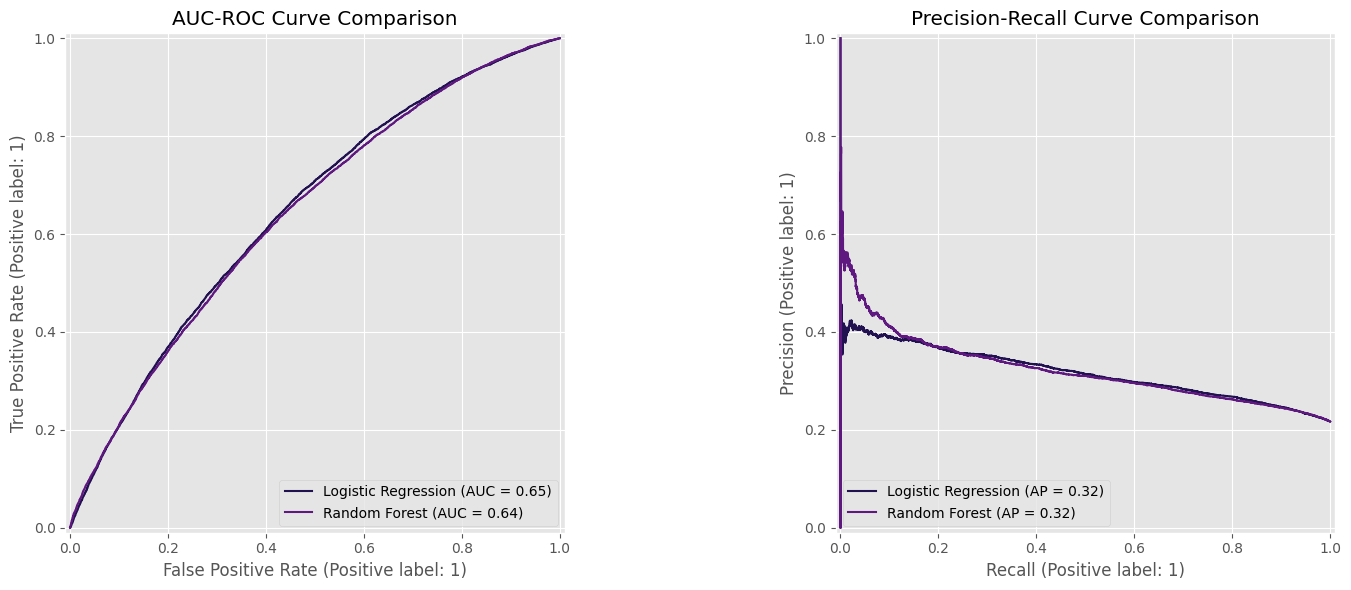

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

RocCurveDisplay.from_estimator(lr_base, X_test_scaled, y_test, ax=ax1, name='Logistic Regression')
RocCurveDisplay.from_estimator(rf_base, X_test, y_test, ax=ax1, name='Random Forest')
ax1.set_title('AUC-ROC Curve Comparison')

PrecisionRecallDisplay.from_estimator(lr_base, X_test_scaled, y_test, ax=ax2, name='Logistic Regression')
PrecisionRecallDisplay.from_estimator(rf_base, X_test, y_test, ax=ax2, name='Random Forest')
ax2.set_title('Precision-Recall Curve Comparison')

plt.tight_layout()
plt.savefig('baseline_curves.png')
plt.show()

## Model Performance Comparison – ROC & Precision-Recall Curves

This section compares **Logistic Regression** and **Random Forest** using threshold-independent evaluation metrics.

---

### ROC-AUC Comparison

**Observations:**
- Logistic Regression: **AUC ≈ 0.65**
- Random Forest: **AUC ≈ 0.64**
- ROC curves largely overlap

**Interpretation:**
- Both models have **similar overall discrimination ability**
- Neither model clearly dominates in separating defaulters from non-defaulters
- Performance is only moderately better than random guessing

---

### Precision-Recall Comparison

**Observations:**
- Average Precision (AP) for both models ≈ **0.32**
- Precision drops rapidly as recall increases
- Curves overlap across most recall ranges

**Interpretation:**
- Class imbalance significantly impacts precision
- High recall comes at the cost of many false positives
- Both models behave similarly when focusing on defaulters

---

### Business Takeaways

- Model choice alone does not drive performance improvement
- Gains will come from:
  - Class imbalance handling (SMOTE / class weights)
  - Threshold optimization
  - Feature interactions and non-linear transformations

---

### Conclusion

Both Logistic Regression and Random Forest show **comparable baseline performance** across ROC and Precision-Recall metrics. This confirms that **feature engineering and optimization** are more critical than switching algorithms at this stage.


## Confusion Matrix Analysis
Displaying TN, FP, FN, TP for a clearer view of classification errors.

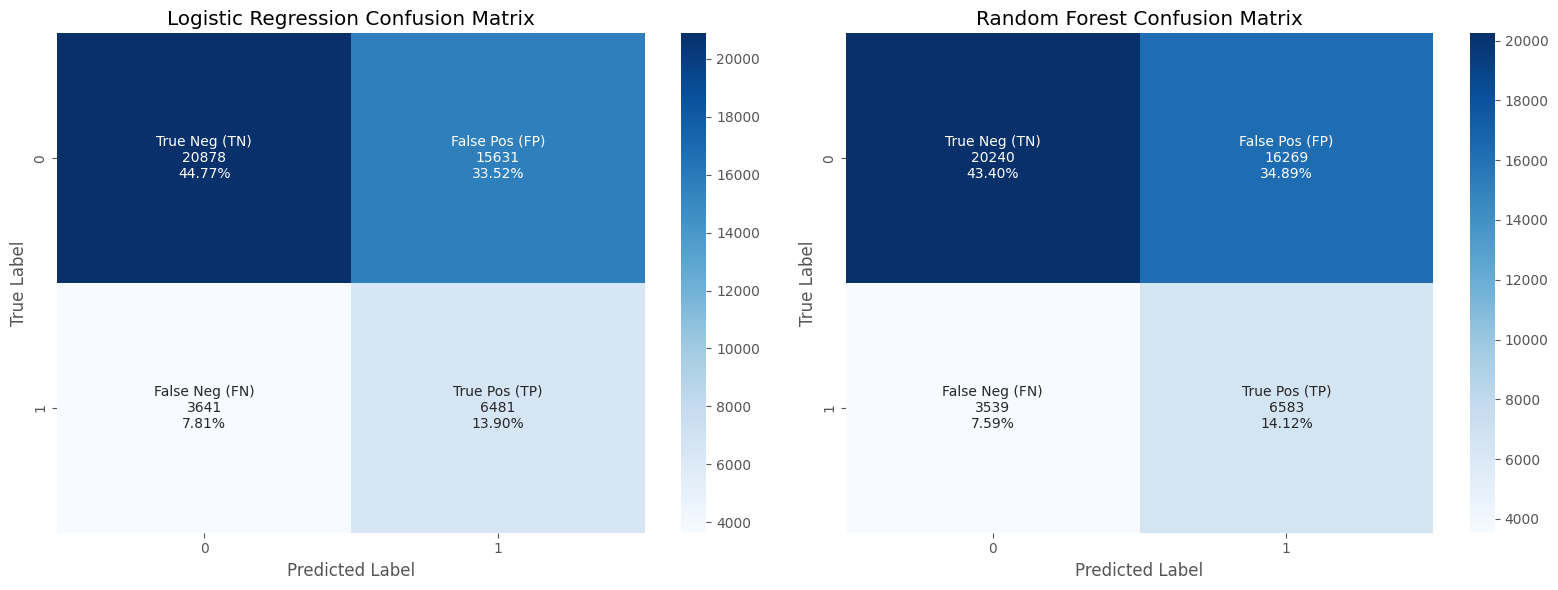

In [7]:
def plot_labeled_confusion_matrix(y_true, y_pred, title, ax):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    cm = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg (TN)','False Pos (FP)','False Neg (FN)','True Pos (TP)']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_labeled_confusion_matrix(y_test, y_pred_lr, 'Logistic Regression Confusion Matrix', axes[0])
plot_labeled_confusion_matrix(y_test, y_pred_rf, 'Random Forest Confusion Matrix', axes[1])
plt.tight_layout()
plt.show()

## Confusion Matrix Comparison – Logistic Regression vs Random Forest

This comparison highlights how both models classify **defaulters (1)** and **non-defaulters (0)** at the chosen threshold.

---

### Logistic Regression

- **True Negatives:** 44.8% → good at identifying safe borrowers  
- **False Positives:** 33.5% → many safe borrowers flagged as risky  
- **False Negatives:** 7.8% → some defaulters missed  
- **True Positives:** 13.9% → moderate defaulter capture  

**Interpretation:**  
Logistic Regression prioritizes **recall for defaulters**, but at the cost of higher false alarms.

---

### Random Forest

- **True Negatives:** 43.4% → slightly lower than Logistic Regression  
- **False Positives:** 34.9% → marginally higher false alarms  
- **False Negatives:** 7.6% → slightly fewer missed defaulters  
- **True Positives:** 14.1% → marginal improvement in defaulter detection  

**Interpretation:**  
Random Forest captures **slightly more defaulters**, but overall error trade-offs remain similar.

---

### Key Takeaways

- Both models show **very similar error patterns**
- High **false positives** reflect class imbalance and conservative risk detection
- Differences between models are **marginal at baseline**

**Conclusion:**  
Confusion matrices confirm that **threshold tuning, imbalance handling, and feature interactions** will deliver larger gains than switching between these two baseline models.


## 6. Next Steps
1. Optimize decision threshold for Random Forest.
2. Implement XGBoost and LightGBM for better performance.
3. Perform hyperparameter tuning.